In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import json
import DownArrow as dn

In [2]:
G = nx.complete_graph(7) # choose graph

P = dn.Graph_Ideal(G, nx.DiGraph(), 1) #generate the ideal

#diagnostic graphs = nx.get_node_attributes(P, "graph")

positions = dn.calculate_positions(P)

dn.build_and_print_json(P) #generates the json file for the ideal


#nx.draw_networkx(P, pos=nx.spring_layout(P), with_labels=True)

In [ ]:
#run this cell for a preview drawing
plt.figure(figsize=(20, 30))
nx.draw_networkx(P, pos=positions, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_weight="bold")
plt.show()

In [31]:
H = nx.complete_bipartite_graph(2,3)
H.add_node('5')
G = nx.complete_graph(6)
P = dn.Graph_Ideal(G, nx.DiGraph(), 1)
print(dn.graph_to_node(H,P))

0-0-0-0-0-0-3-8-16-18


In [3]:
ramsey_set = dn.down_arrow_ramsey_set(nx.complete_graph(7))

In [76]:
P = dn.Graph_Ideal(nx.complete_graph(6), nx.DiGraph(), 1)
graphs = nx.get_node_attributes(P, 'graph')
ramsey_set_graphs = []
for node in ramsey_set:
    ramsey_set_graphs.append(graphs[node])

In [4]:

json_ramsey_set = {'toHighlight': list(ramsey_set)}


json_str = json.dumps(json_ramsey_set, indent=2)
with open('ramsey_set.json', 'w') as f:
    json.dump(json_ramsey_set, f, indent=2)

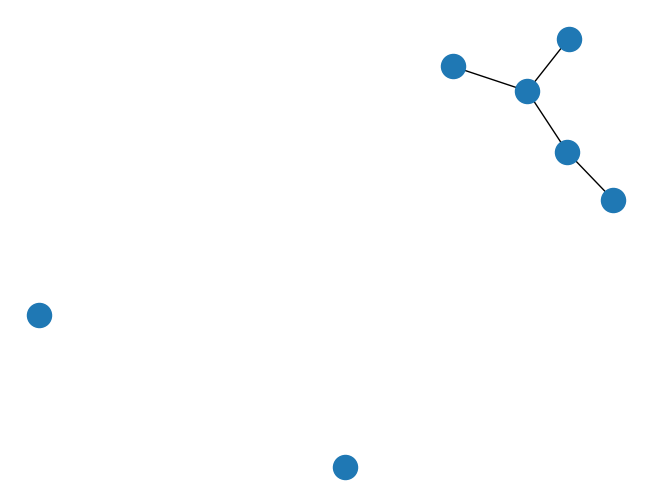

In [80]:
nx.draw(ramsey_set_graphs[3])

In [22]:
set1 = set([1,2,3,4,5])
set2 = {2,3,4,7}
set3 = set1.union(set2)
print(set3)

{1, 2, 3, 4, 5, 7}
